In [128]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append('/home/users/jamd1/Isca/')
from isca_tools.utils.moist_physics import sphum_from_dew
print(os.getcwd())

/home/users/jamd1/Isca/jobs


In [33]:
dir_base = '/gws/nopw/j04/global_ex/jamd1/era5/'
t2m_av_use = 'max'
dir_t2m = {key: os.path.join(dir_base, f'daily_{key}', 't2m') for key in ['mean', 'max']}[t2m_av_use]
     # get variables conditioned on annual maximum of daily max or mean temperature

In [36]:
# Select all years for given lat range, and only keep land coordinates
lat_min = 40
lat_max = 65
ds = xr.open_mfdataset(f"{dir_t2m}/*.nc", combine='by_coords').sel(latitude=slice(lat_max, lat_min))
lsm = xr.load_dataset('/home/users/jamd1/Isca/jobs/era5/invariants/lsm1979.nc').lsm.squeeze()
lsm = lsm.reindex(latitude=ds.latitude, longitude=ds.longitude, method="nearest")
ds = ds.where(lsm>0)
months_keep = [5, 6, 7, 8, 9] # keep extended summer as need to do quantile thresholding across time
ds = ds.sel(time=ds.time.dt.month.isin(months_keep))
ds = ds.load()

In [76]:
months_keep = [5, 6, 7, 8, 9]

In [81]:
quant_thresh_all = 0.95         # keep hottest 5% of days throughout entire year
# convert hottest 5% of entire year into fraction of summer month days to keep i.e. assume all hot days are in summer
n_keep = (1-quant_thresh_all) * ds.time.size * 12 / len(months_keep)
quant_thresh_hot = 1 - n_keep/ds.time.size
thresh_hot = ds.t2m.quantile(quant_thresh_hot, dim='time')
is_hot = ds.t2m >= thresh_hot

In [49]:
def climatological_window_quantile_loop(da, q=0.99, window=15, months_include=[6, 7, 8]):
    """Compute climatological moving-window quantile over all years.

    Args:
        da (xr.DataArray): Input data with time dimension.
        q (float): Quantile to compute (0–1).
        window (int): Window size in days (should be odd).
        months_include (list): List of months to consider.

    Returns:
        xr.DataArray: Quantile with dims (dayofyear, lat, lon, ...)
    """
    half = window // 2
    doy = da["time"].dt.dayofyear

    days_unique = np.unique(doy.sel(time=da.time.dt.month.isin(months_include)))
    results = []
    for i in tqdm(range(len(days_unique))):  # 1..366
        d = days_unique[i]
        # define window around day d
        days = np.arange(d - half, d + half + 1)
        # wrap around year boundaries
        days = (days - 1) % 366 + 1
        mask = doy.isin(days)
        qval = da.where(mask, drop=True).quantile(q, dim="time")
        results.append(qval.assign_coords(dayofyear=d))

    return xr.concat(results, dim="dayofyear")
# thresh_anom = climatological_window_quantile(ds.t2m)

  0%|          | 0/93 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [71]:
def climatological_window_quantile(da, q=0.99, window=15, months_include=[6, 7, 8]):
    """Compute climatological moving-window quantile over all years.

    Args:
        da (xr.DataArray): Input data with time dimension.
        q (float): Quantile to compute (0–1).
        window (int): Window size in days (should be odd).
        months_include (list): List of months to consider.

    Returns:
        xr.DataArray: Quantile with dims (dayofyear, lat, lon, ...)
    """
    half_window = window // 2
    lags = range(-half_window, half_window + 1)
    shifted = []
    for lag in lags:
        shifted.append(da.shift(time=lag))
    # stack into new lag dimension
    da_lag = xr.concat(shifted, dim="lag")
    # only include central months to avoid padding issues
    da_lag = da_lag.sel(time=da_lag.time.dt.month.isin(months_include))
    # now group by dayofyear and compute quantile across (time, lag)
    result = da_lag.groupby(da_lag.time.dt.dayofyear).reduce(
        np.nanquantile, dim=("time", "lag"), q=q)
    return result
thresh_anom = climatological_window_quantile(ds.t2m)  # takes about 50 minutes

In [72]:
thresh_anom.to_netcdf('/home/users/jamd1/thresh_anom_era5.nc')

In [93]:
ds_use = ds.sel(time=ds.time.dt.month.isin([6, 7, 8]))
thresh_anom_time = thresh_anom.sel(dayofyear=ds_use.time.dt.dayofyear)
is_hot_anom = ds_use.t2m >= thresh_anom_time

In [108]:
# Number of hot days outside JJA summer of main consideration
hot_frac_MS = (is_hot.sel(time=ds.time.dt.month.isin([5, 9])).sum(dim='time') / is_hot.sum(dim='time')).where(lsm>0)
# Number of hot days that are anomalous for that time of year
hot_and_anom_frac = ((is_hot_anom & is_hot.sel(time=ds.time.dt.month.isin([6, 7, 8]))).sum(dim='time') /  is_hot.sum(dim='time')).where(lsm>0)
# Number of hot days that are not anomalous for that time of year
hot_not_anom_frac = ((~is_hot_anom & is_hot.sel(time=ds.time.dt.month.isin([6, 7, 8]))).sum(dim='time') /  is_hot.sum(dim='time')).where(lsm>0)
# Number of days that are anomalous for the time of year but that are not hot in absolute terms
anom_not_hot_frac = ((is_hot_anom & ~is_hot.sel(time=ds.time.dt.month.isin([6, 7, 8]))).sum(dim='time') /  is_hot.sum(dim='time')).where(lsm>0)

Text(0.5, 1.0, 'Absolute Hot and Anomalous Day Fraction')

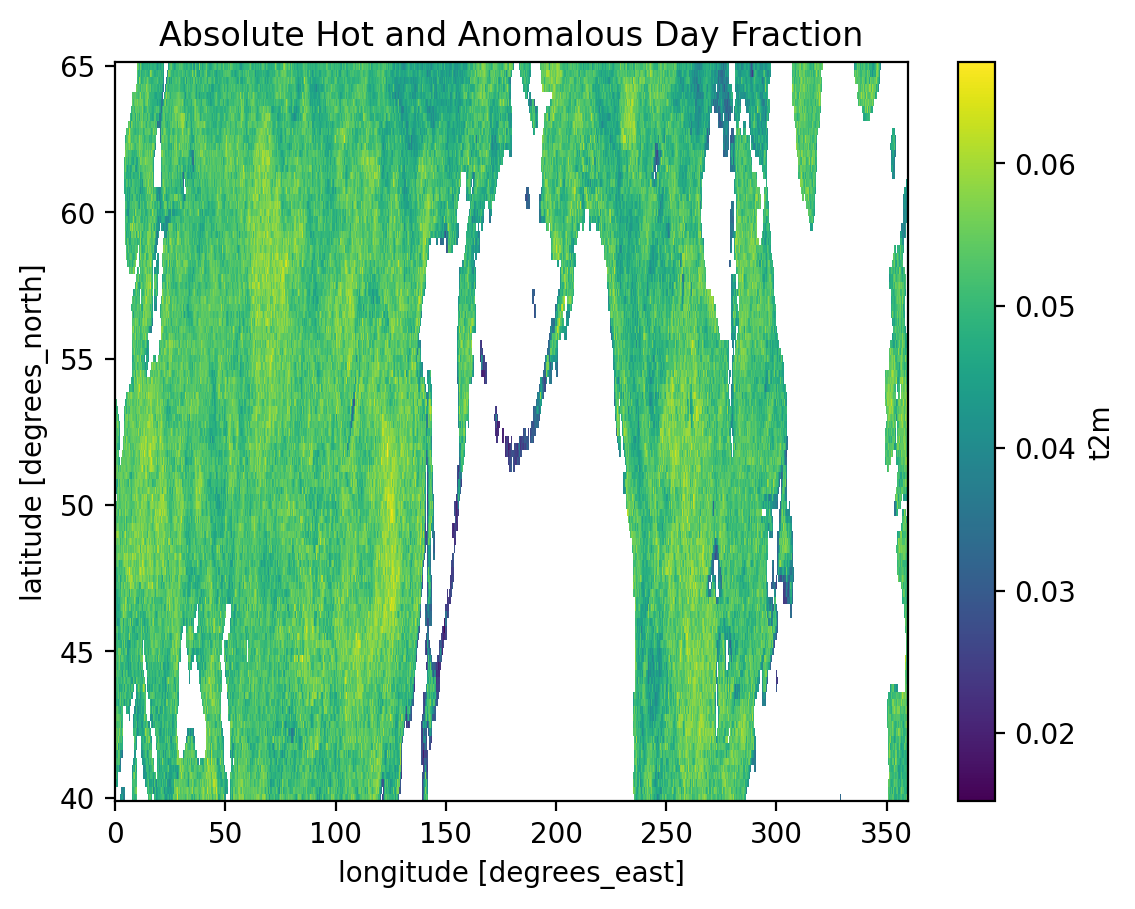

In [130]:
hot_and_anom_frac.plot()
plt.gca().set_title('Absolute Hot and Anomalous Day Fraction')